In [1]:
import tensorflow as tf

print(f"CUDA Available: {tf.config.list_physical_devices('GPU')}")
print(f"CUDA Version: {tf.sysconfig.get_build_info()['cuda_version']}")
print(f"cuDNN Version: {tf.sysconfig.get_build_info()['cudnn_version']}")

2025-01-28 11:48:10.358321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738057690.411227   10164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738057690.427126   10164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 11:48:10.551933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Version: 12.5.1
cuDNN Version: 9


In [1]:
import tensorflow as tf
from tensorflow import keras  # type: ignore
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers  # type: ignore
import seaborn as sns
from sklearn.metrics import classification_report
from keras.models import load_model  # type: ignore
from tensorflow.keras.applications import ResNet152  # type: ignore
from tensorflow.keras.applications.vgg19 import VGG19  # type: ignore
from tensorflow.keras.applications import ResNet50  # type: ignore
from tensorflow.keras.applications.resnet50 import preprocess_input  # type: ignore

2025-01-25 14:39:10.701820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737808750.755139   15998 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737808750.771918   15998 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 14:39:10.898395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
batch_size = 32
img_height = 256
img_width = 256

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/home/abdo/Code/Python/Deep_Learning/plant_village/training/plantvillage_dataset",
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 24404 files belonging to 17 classes.


I0000 00:00:1737808757.928223   15998 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4164 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
class_names = dataset.class_names
class_names

['Cucumber__Anthracnose',
 'Cucumber__Bacterial Wilt',
 'Cucumber__Downy Mildew',
 'Cucumber__Fresh Leaf',
 'Cucumber__Gummy_Stem_Blight',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato___mosaic_virus']

In [5]:
len(class_names)

17

763*32= 24416 image

In [6]:
len(dataset)

763

2025-01-25 14:39:55.283283: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


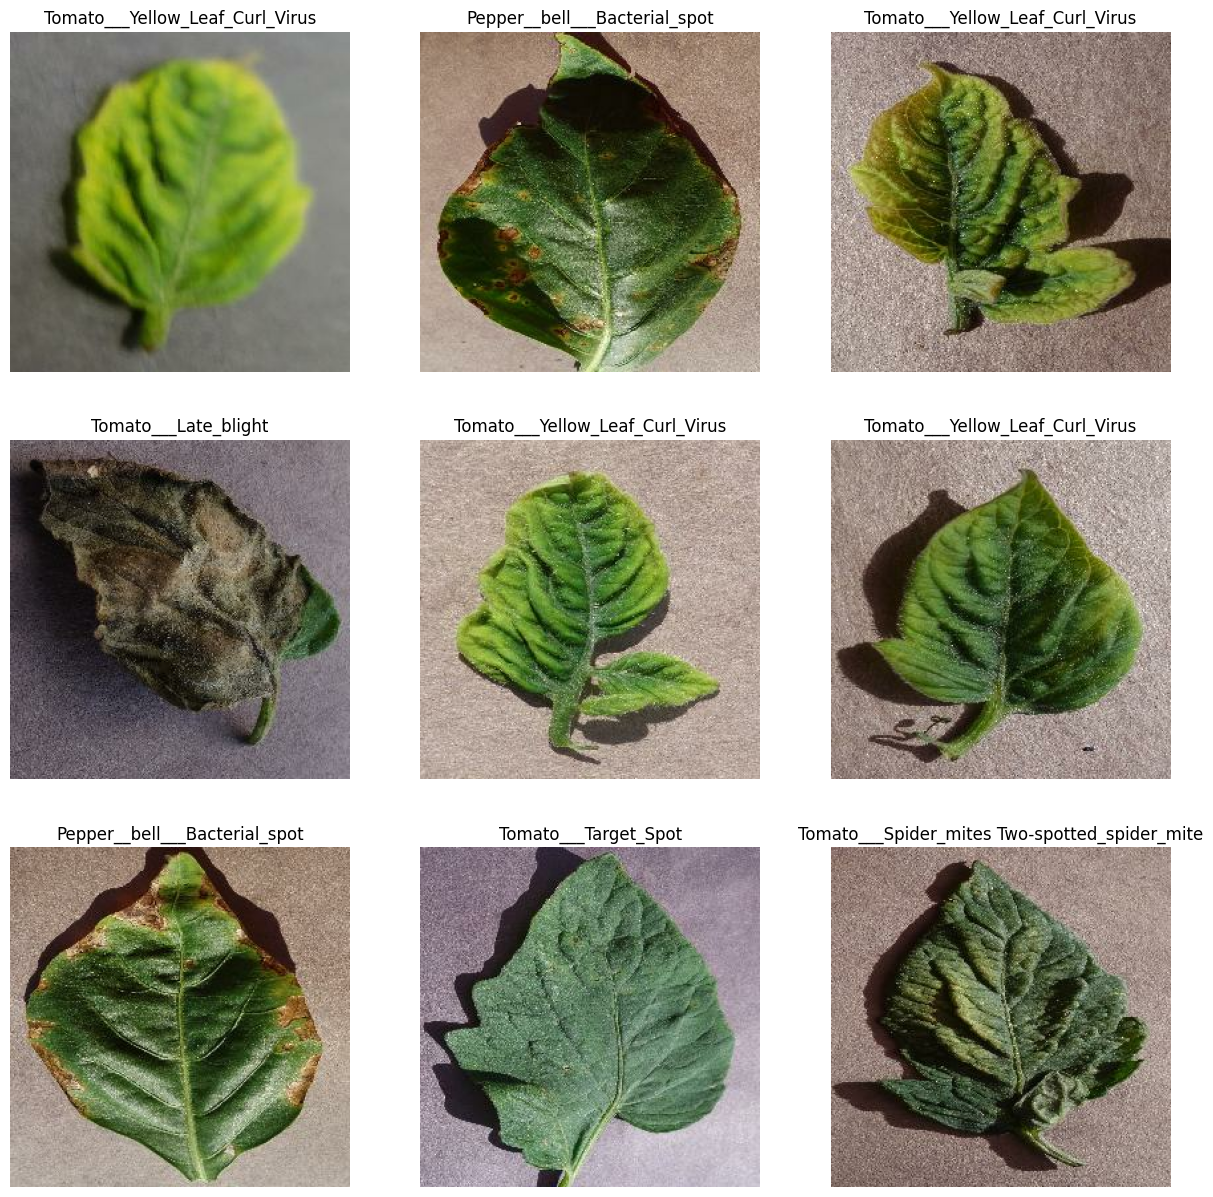

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, batch_label in dataset.take(1):  # take first batch (first 32 image)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(
            class_names[batch_label[i]],
            fontsize=12,
        )
        plt.axis("off")

## split the dataset
- train set: 80% of the data
- validation set: 10% of the data
- test set: 10% of the data

In [8]:
def get_dataset_partitions_tf(
    ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=1000
):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)  # 68
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)  # 0.8*68=54
    val_size = int(val_split * ds_size)  # 0.1*68=6

    train_ds = ds.take(train_size)  # 54
    val_ds = ds.skip(train_size).take(val_size)  # it will skip 54 and take 6
    test_ds = ds.skip(train_size).skip(
        val_size
    )  # it will skip 54 and skip  6 and take 8
    return train_ds, val_ds, test_ds

In [9]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [10]:
def plot_training(hist):
    """
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    """

    # Define needed variables
    tr_acc = hist.history["accuracy"]
    tr_loss = hist.history["loss"]
    val_acc = hist.history["val_accuracy"]
    val_loss = hist.history["val_loss"]

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i + 1 for i in range(len(tr_acc))]

    loss_label = f"best epoch= {str(index_loss + 1)}"
    acc_label = f"best epoch= {str(index_acc + 1)}"

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use("fivethirtyeight")

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, "r", label="Training loss")
    plt.plot(Epochs, val_loss, "g", label="Validation loss")
    plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
    plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
    plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout
    plt.show()

## Data preprocessing

### Data Scaling

In [11]:
resize_and_rescale_layers = tf.keras.Sequential(
    [
        layers.Resizing(img_height, img_width),  ## to resize the unseen images
        layers.Rescaling(1.0 / 255),  ## MinMax scaling
    ]
)

In [12]:
augmentation_layers = tf.keras.Sequential(
    [
        layers.RandomFlip(
            "horizontal_and_vertical", input_shape=(img_height, img_width, 3)
        ),
        layers.RandomBrightness(0.1),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

/home/abdo/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualize a few augmented examples

2025-01-25 14:40:09.923510: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


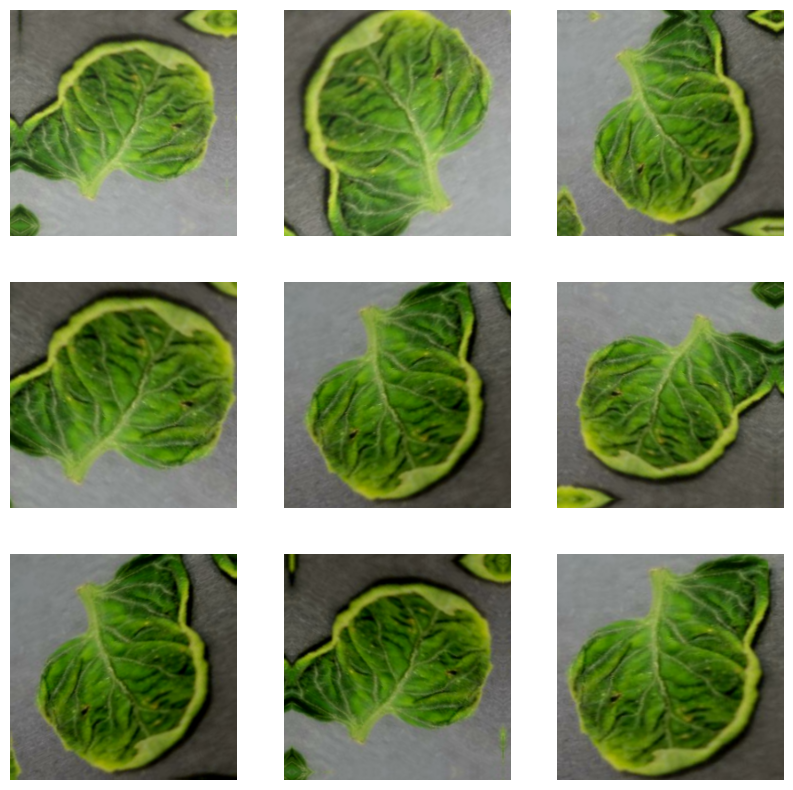

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
n_classes = len(class_names)

cnn_model = tf.keras.Sequential(
    [
        ## pre processing layers
        augmentation_layers,
        resize_and_rescale_layers,
        ## feature extraction layers (Conv2D + Maxpolling2D)
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        ## classification layers (fully connected layers)
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        # layers.Dropout(0.2),  # dropout layer
        layers.Dense(n_classes, activation="softmax"),  # output layer
    ]
)

In [15]:
cnn_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [16]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,169 (418.63 KB)

 Trainable params: 107,169 (418.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs = 300
cnn_history = cnn_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs,
)

Epoch 1/300


I0000 00:00:1735214128.949466    6858 cuda_dnn.cc:529] Loaded cuDNN version 90300


610/610 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.3035 - loss: 2.2161 - val_accuracy: 0.3877 - val_loss: 1.9477
Epoch 2/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6210 - loss: 1.0886 - val_accuracy: 0.5580 - val_loss: 1.4806
Epoch 3/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.7179 - loss: 0.8022 - val_accuracy: 0.5991 - val_loss: 1.3148
Epoch 4/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7730 - loss: 0.6444 - val_accuracy: 0.7081 - val_loss: 0.9163
Epoch 5/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8020 - loss: 0.5579 - val_accuracy: 0.6698 - val_loss: 1.0924
Epoch 6/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8229 - loss: 0.4951 - val_accuracy: 0.7270 - val_loss: 0.8050
Epoch 7/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8305 - loss: 0.4670 - val_accuracy: 0.6731 - val_loss: 1.0513
Epoch 8/300
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8493 - loss: 0.4202 - val_

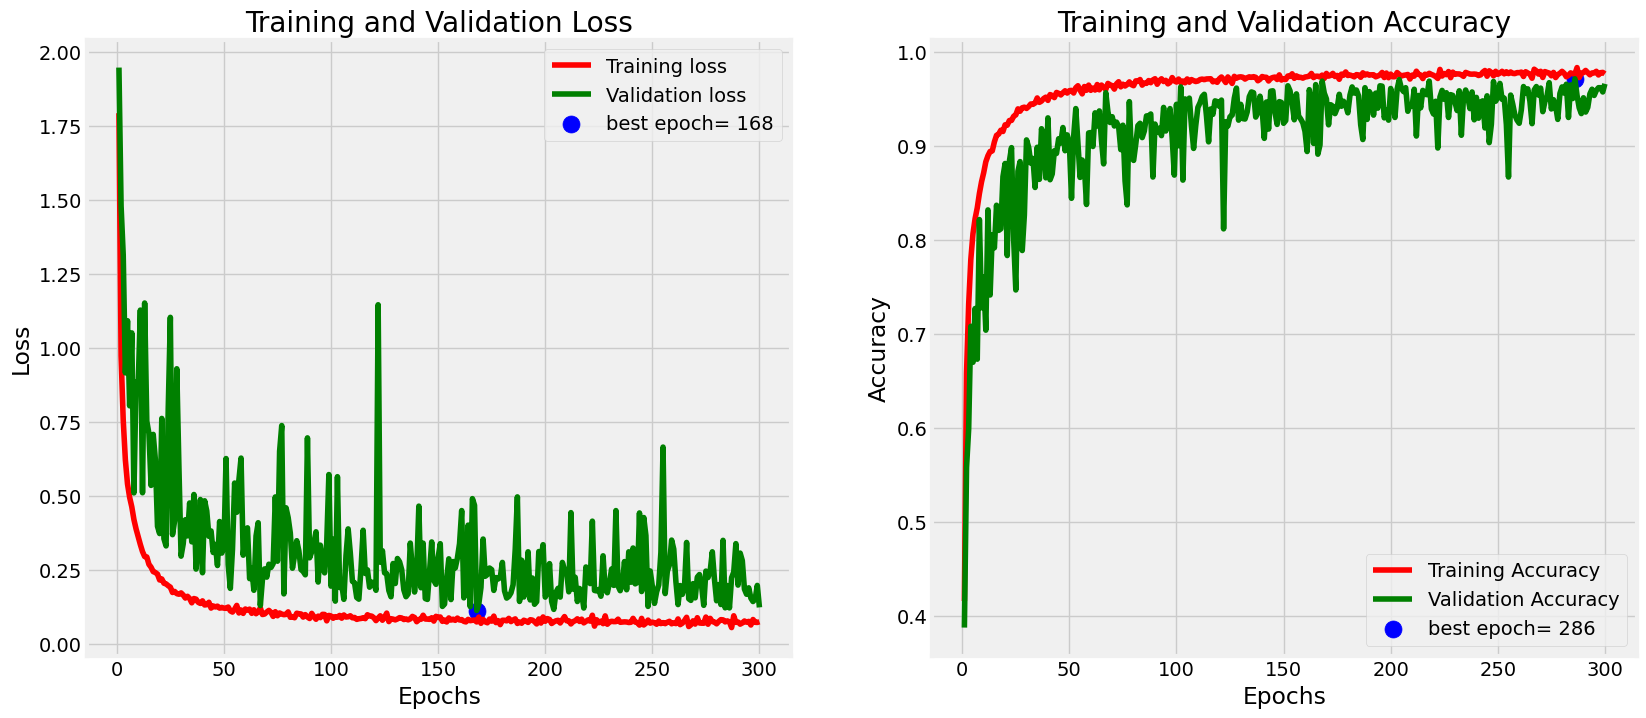

In [18]:
plot_training(cnn_history)

In [19]:
cnn_score = cnn_model.evaluate(test_dataset)
cnn_accuracy = round(cnn_score[1] * 100, 2)
cnn_accuracy

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9635 - loss: 0.1546


95.76

In [20]:
cnn_model_version = f"cnn_{cnn_accuracy}%"
cnn_model_path = f"new_dataset_models/{cnn_model_version}.keras"
cnn_model.save(cnn_model_path)

#### Making predictions

In [21]:
def user_predict(model, image_batch):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())  # type: ignore
    # add a batch_size dimension
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)  ## predictions[0] ex: [0.1,0.5,0.4]

    predicted_class = np.argmax(predictions[0])
    confidence = round((np.max(predictions[0])) * 100, 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


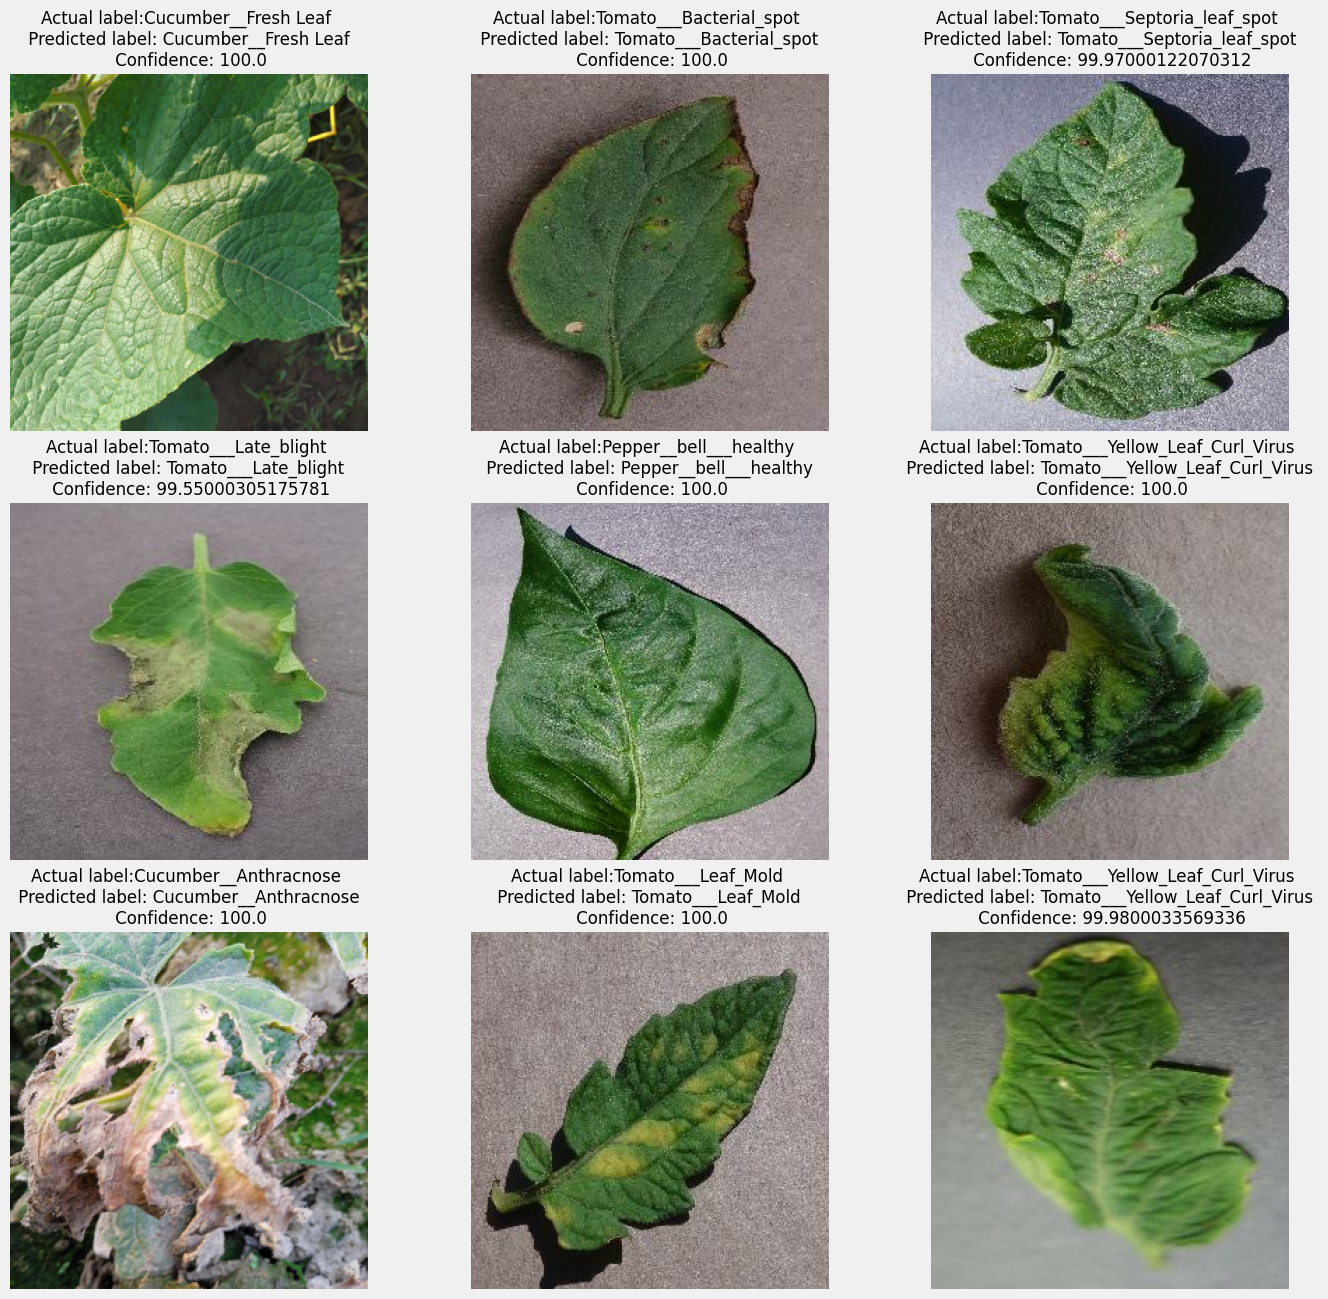

In [22]:
plt.figure(figsize=(15, 15))
for image_batch, batch_label in dataset.take(1):  # take first batch (first 32 image)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(image_batch[i].numpy().astype("int"))
        predicted_class, confidence = user_predict(cnn_model, image_batch)
        plt.title(
            f"Actual label:{class_names[batch_label[i]]} \n Predicted label: {class_names[predicted_class]} \n Confidence: {confidence}",
            fontsize=12,
        )

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

2024-12-26 16:00:47.497888: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


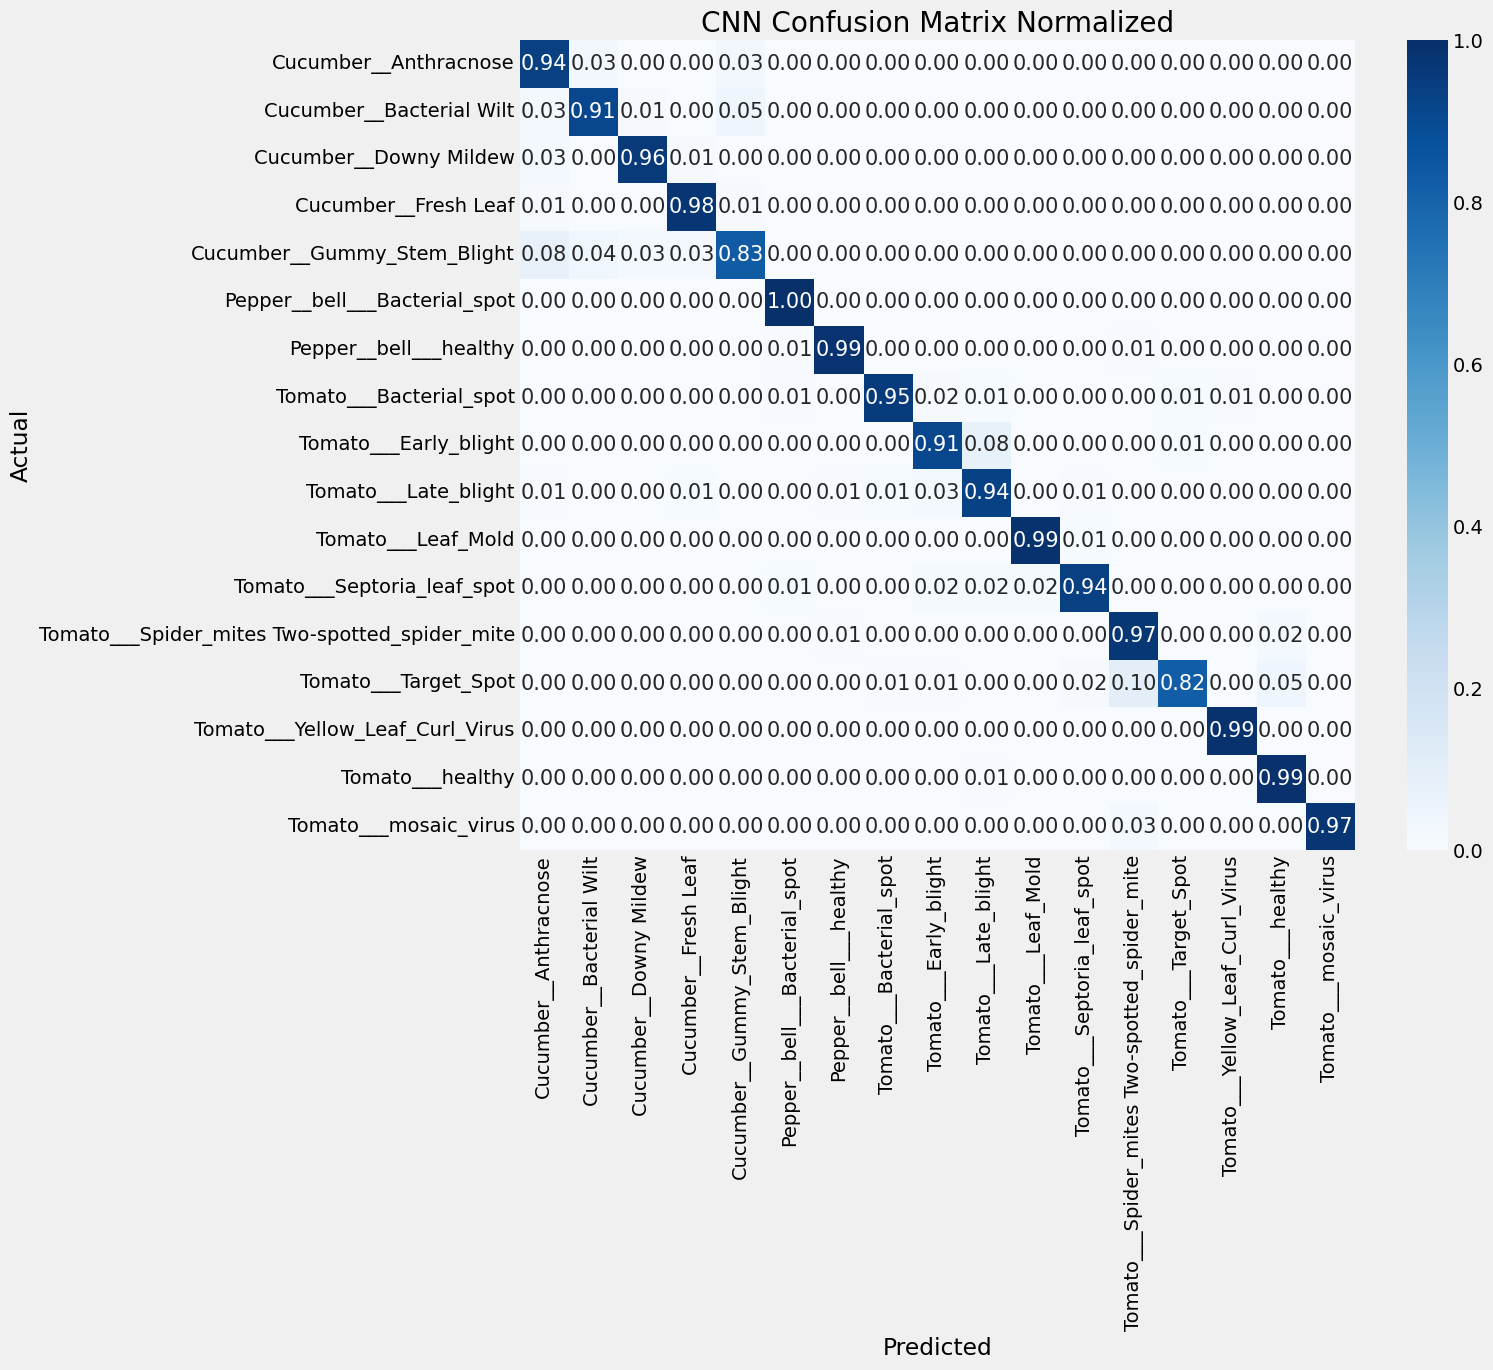

In [23]:
cnn_true_labels = []
cnn_predicted_labels = []

# Iterate through the dataset to get true labels and predictions
for image_batch, label_batch in test_dataset:
    predictions = cnn_model.predict(image_batch)
    cnn_predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    cnn_true_labels.extend(label_batch.numpy())

# Convert lists to tensors
cnn_true_labels = tf.convert_to_tensor(cnn_true_labels)
cnn_predicted_labels = tf.convert_to_tensor(cnn_predicted_labels)

cnn_cm = tf.math.confusion_matrix(
    labels=cnn_true_labels,
    predictions=cnn_predicted_labels,
    num_classes=len(class_names),
)

# Normalize the confusion matrix
cnn_cm_normalized = cnn_cm / tf.reduce_sum(cnn_cm, axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cnn_cm_normalized.numpy(),
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 15},  # Increase numbers font size
)
plt.title("CNN Confusion Matrix Normalized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
print(
    classification_report(
        cnn_true_labels, cnn_predicted_labels, target_names=class_names
    )
)

                                               precision    recall  f1-score   support

                        Cucumber__Anthracnose       0.84      0.94      0.89        66
                     Cucumber__Bacterial Wilt       0.94      0.91      0.92        80
                       Cucumber__Downy Mildew       0.96      0.96      0.96        79
                         Cucumber__Fresh Leaf       0.94      0.98      0.96        83
                  Cucumber__Gummy_Stem_Blight       0.90      0.83      0.87        78
                Pepper__bell___Bacterial_spot       0.96      1.00      0.98       113
                       Pepper__bell___healthy       0.99      0.99      0.99       145
                      Tomato___Bacterial_spot       0.98      0.95      0.97       196
                        Tomato___Early_blight       0.88      0.91      0.89       102
                         Tomato___Late_blight       0.92      0.94      0.93       189
                           Tomato___Leaf_M

### ResNet152 model

In [20]:
epochs_transfer = 20

In [35]:
## load Resnet152 model without classification layers (top layers)
resnet_base_model = ResNet152(
    include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)
)

# Freeze the base model to prevent its weights from being updated during training
resnet_base_model.trainable = False

# Define the model using Sequential
resnet_model = tf.keras.Sequential(
    [
        # augmentation_layers,  # Data augmentation
        resnet_base_model,  # Add the pre-trained base model
        layers.GlobalAveragePooling2D(),  # Global average pooling layer
        layers.Dense(n_classes, activation="softmax"),  # Output layer
    ]
)
resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 8, 8, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,405,777 (222.80 MB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [36]:
resnet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [37]:
resnet_history = resnet_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=10,
)

Epoch 1/20


I0000 00:00:1735053947.066070    4869 service.cc:148] XLA service 0x1affed80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735053947.101887    4869 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-24 17:25:47.626452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-24 17:25:51.575828: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14346', 320 bytes spill stores, 320 bytes spill loads

2024-12-24 17:25:51.644862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14346', 364 bytes spill stores, 364 bytes spill loads

2024-12-24 17:25:51.692541: I ex

  1/610 ━━━━━━━━━━━━━━━━━━━━ 3:19:32 20s/step - accuracy: 0.0312 - loss: 3.5491

I0000 00:00:1735053955.589372    4869 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


610/610 ━━━━━━━━━━━━━━━━━━━━ 146s 207ms/step - accuracy: 0.7415 - loss: 0.8552 - val_accuracy: 0.9371 - val_loss: 0.2208
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.9437 - loss: 0.1891 - val_accuracy: 0.9523 - val_loss: 0.1774
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9657 - loss: 0.1258 - val_accuracy: 0.9581 - val_loss: 0.1430
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9775 - loss: 0.0917

2024-12-24 17:33:54.204976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9775 - loss: 0.0917 - val_accuracy: 0.9679 - val_loss: 0.1199
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9837 - loss: 0.0712 - val_accuracy: 0.9638 - val_loss: 0.1254
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9861 - loss: 0.0582 - val_accuracy: 0.9671 - val_loss: 0.1160
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 199ms/step - accuracy: 0.9911 - loss: 0.0456 - val_accuracy: 0.9720 - val_loss: 0.0984
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9945 - loss: 0.0362

2024-12-24 17:42:01.504026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9945 - loss: 0.0362 - val_accuracy: 0.9700 - val_loss: 0.1121
Epoch 9/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 199ms/step - accuracy: 0.9938 - loss: 0.0318 - val_accuracy: 0.9745 - val_loss: 0.1000
Epoch 10/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 199ms/step - accuracy: 0.9966 - loss: 0.0250 - val_accuracy: 0.9725 - val_loss: 0.0999
Epoch 11/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 199ms/step - accuracy: 0.9962 - loss: 0.0217 - val_accuracy: 0.9733 - val_loss: 0.1030
Epoch 12/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9976 - loss: 0.0181

2024-12-24 17:50:08.086310: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 41942784 bytes after encountering the first element of size 41942784 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9976 - loss: 0.0181 - val_accuracy: 0.9737 - val_loss: 0.1023
Epoch 13/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 125s 205ms/step - accuracy: 0.9981 - loss: 0.0154 - val_accuracy: 0.9679 - val_loss: 0.1184
Epoch 14/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 125s 205ms/step - accuracy: 0.9987 - loss: 0.0134 - val_accuracy: 0.9688 - val_loss: 0.1200
Epoch 15/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 123s 201ms/step - accuracy: 0.9994 - loss: 0.0111 - val_accuracy: 0.9708 - val_loss: 0.1009
Epoch 16/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 123s 201ms/step - accuracy: 0.9989 - loss: 0.0109 - val_accuracy: 0.9741 - val_loss: 0.1049
Epoch 17/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9988 - loss: 0.0098

2024-12-24 18:00:25.196084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9988 - loss: 0.0098 - val_accuracy: 0.9688 - val_loss: 0.1086
Epoch 18/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9964 - loss: 0.0141 - val_accuracy: 0.9737 - val_loss: 0.1039
Epoch 19/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9996 - loss: 0.0062 - val_accuracy: 0.9741 - val_loss: 0.1038
Epoch 20/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9993 - loss: 0.0066 - val_accuracy: 0.9712 - val_loss: 0.1027


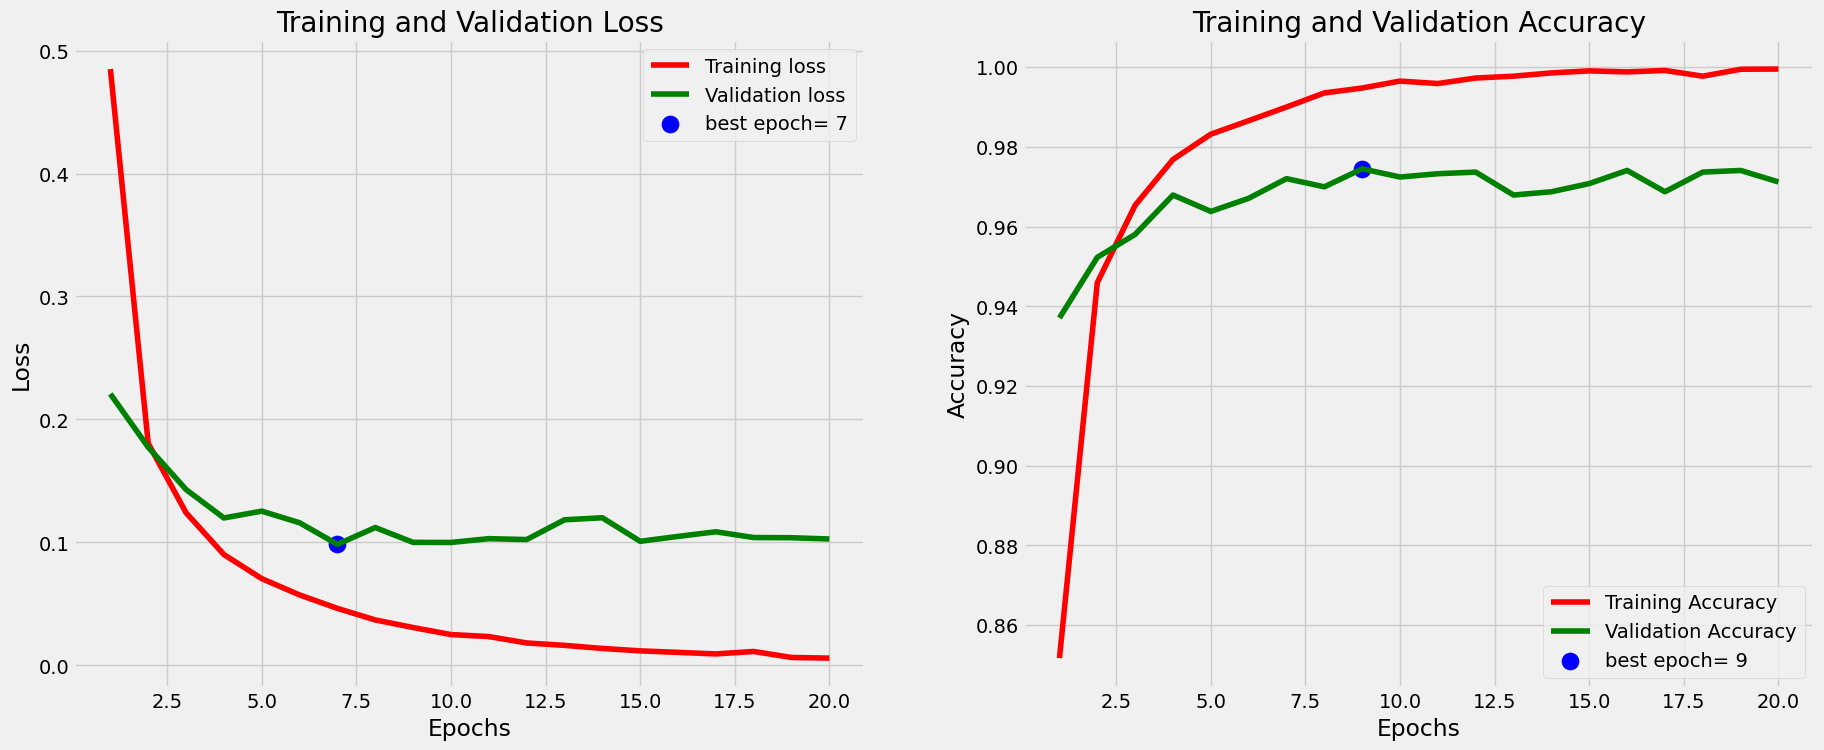

In [38]:
plot_training(resnet_history)

In [39]:
resnet_score = resnet_model.evaluate(test_dataset)
resnet_accuracy = round(resnet_score[1] * 100, 2)
resnet_accuracy

76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9822 - loss: 0.0753

2024-12-24 18:07:07.812117: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4892', 8 bytes spill stores, 8 bytes spill loads

2024-12-24 18:07:07.901504: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4892', 476 bytes spill stores, 316 bytes spill loads

2024-12-24 18:07:07.938637: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4892', 580 bytes spill stores, 412 bytes spill loads

2024-12-24 18:07:07.974531: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4892', 648 bytes spill stores, 476 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - accuracy: 0.9822 - loss: 0.0751


98.16

In [40]:
resnet_model_version = f"resnet152_{resnet_accuracy}%"
resnet_model_path = f"new_dataset_models/{resnet_model_version}.keras"
resnet_model.save(resnet_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

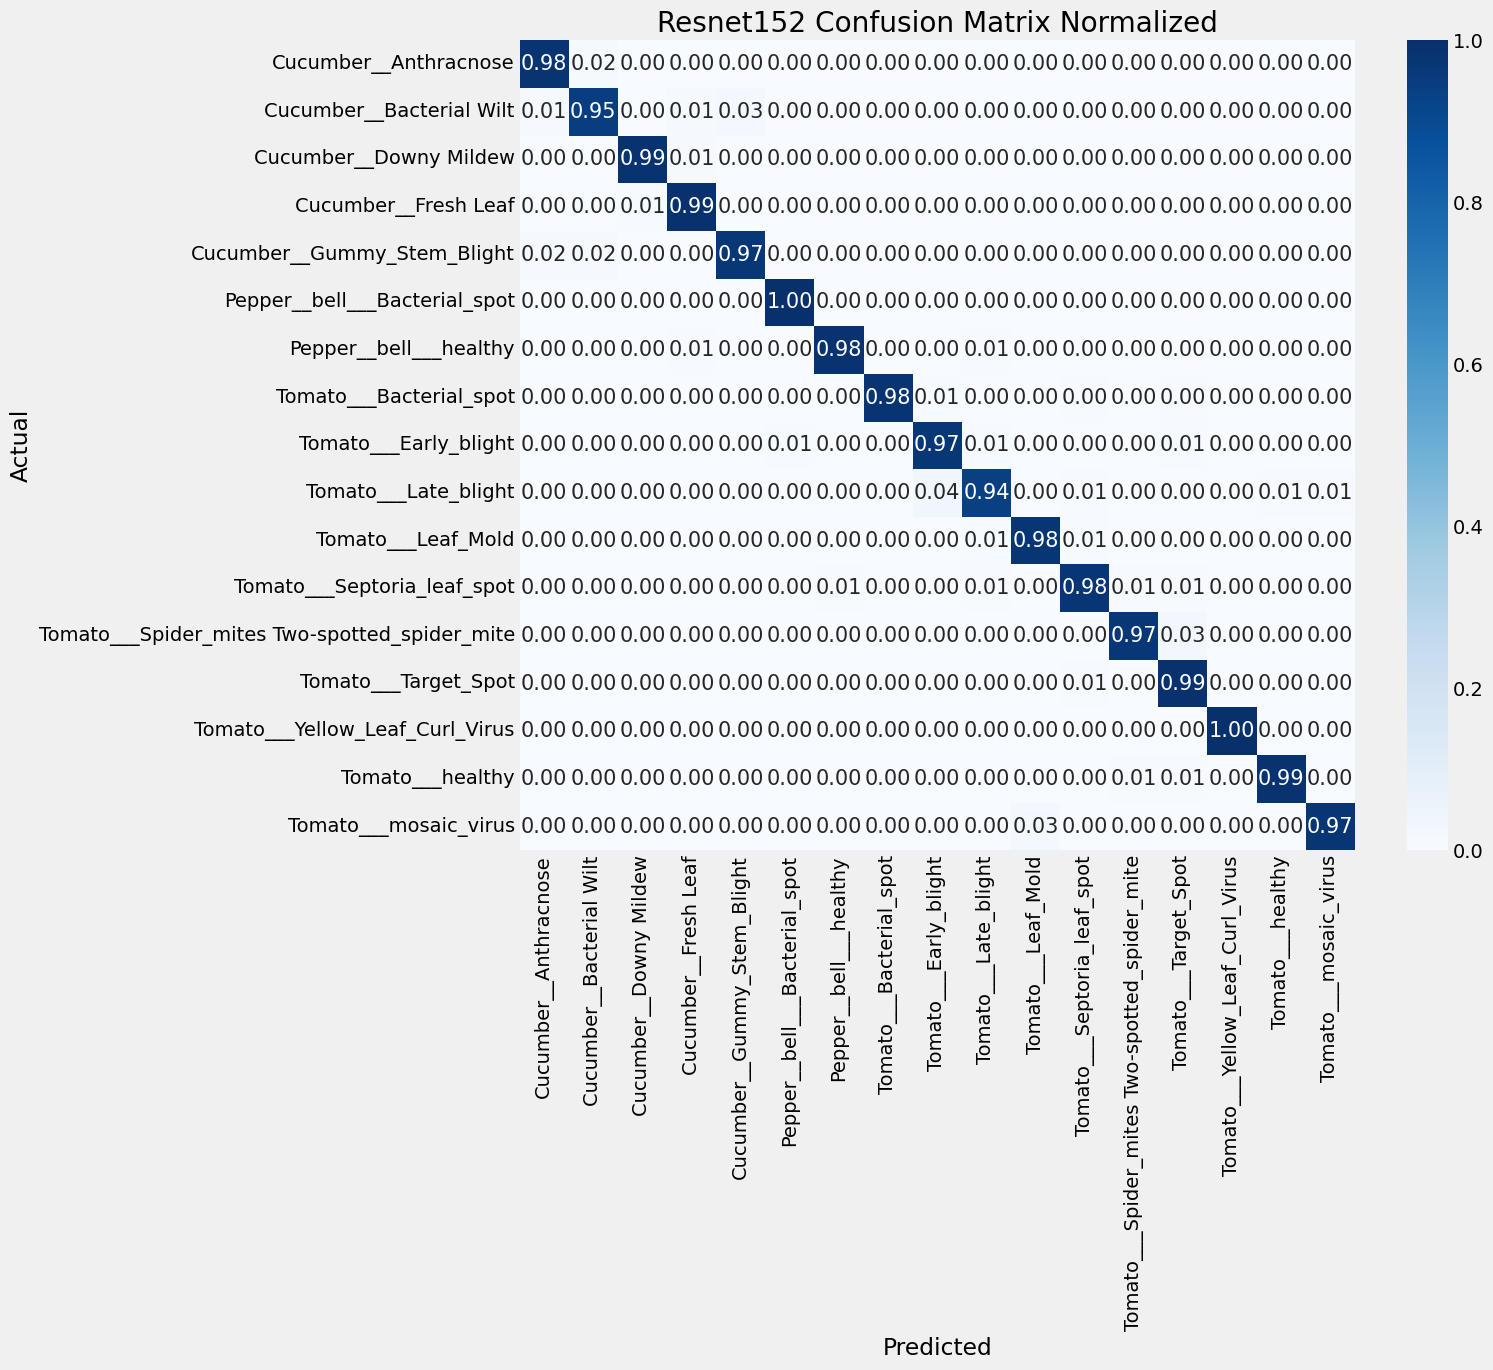

In [41]:
# Assuming cnn_model is your trained model and test_dataset is your tf.data.Dataset
resnet_true_labels = []
resnet_predicted_labels = []

# Iterate through the dataset to get true labels and predictions
for image_batch, label_batch in test_dataset:
    predictions = resnet_model.predict(image_batch)
    resnet_predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    resnet_true_labels.extend(label_batch.numpy())

# Convert lists to tensors
resnet_true_labels = tf.convert_to_tensor(resnet_true_labels)
resnet_predicted_labels = tf.convert_to_tensor(resnet_predicted_labels)

resnet_cm = tf.math.confusion_matrix(
    labels=resnet_true_labels,
    predictions=resnet_predicted_labels,
    num_classes=len(class_names),
)

# Normalize the confusion matrix
resnet_cm_normalized = resnet_cm / tf.reduce_sum(resnet_cm, axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    resnet_cm_normalized.numpy(),
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 15},  # Increase numbers font size
)
plt.title("Resnet152 Confusion Matrix Normalized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
print(
    classification_report(
        resnet_true_labels, resnet_predicted_labels, target_names=class_names
    )
)

                                               precision    recall  f1-score   support

                        Cucumber__Anthracnose       0.97      0.98      0.97        57
                     Cucumber__Bacterial Wilt       0.97      0.95      0.96        76
                       Cucumber__Downy Mildew       0.99      0.99      0.99        72
                         Cucumber__Fresh Leaf       0.97      0.99      0.98        91
                  Cucumber__Gummy_Stem_Blight       0.97      0.97      0.97        66
                Pepper__bell___Bacterial_spot       0.99      1.00      1.00       101
                       Pepper__bell___healthy       0.99      0.98      0.99       129
                      Tomato___Bacterial_spot       1.00      0.98      0.99       215
                        Tomato___Early_blight       0.90      0.97      0.93        98
                         Tomato___Late_blight       0.98      0.94      0.96       187
                           Tomato___Leaf_M

### ResNet50 model

In [43]:
## load Resnet50 model without classification layers (top layers)
resnet50_base_model = ResNet50(
    include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)
)

# Freeze the base model to prevent its weights from being updated during training
resnet50_base_model.trainable = False

# Define the model using Sequential
resnet50_model = tf.keras.Sequential(
    [
        # augmentation_layers,  # Data augmentation
        # layers.Lambda(preprocess_input, name="preprocessing"),  # Preprocessing
        resnet50_base_model,  # Add the pre-trained base model
        layers.GlobalAveragePooling2D(),  # Global average pooling layer
        layers.Dense(n_classes, activation="softmax"),  # Output layer
    ]
)
resnet50_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,622,545 (90.11 MB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [44]:
resnet50_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [45]:
resnet50_history = resnet50_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=15,
)

Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7551 - loss: 0.8272

2024-12-24 18:08:46.578765: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33546752 bytes after encountering the first element of size 33546752 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 62s 91ms/step - accuracy: 0.7552 - loss: 0.8266 - val_accuracy: 0.9350 - val_loss: 0.2202
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9437 - loss: 0.1952

2024-12-24 18:09:41.044074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166592 bytes after encountering the first element of size 25166592 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9437 - loss: 0.1952 - val_accuracy: 0.9482 - val_loss: 0.1806
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9616 - loss: 0.1333 - val_accuracy: 0.9560 - val_loss: 0.1374
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9747 - loss: 0.0996 - val_accuracy: 0.9605 - val_loss: 0.1281
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9815 - loss: 0.0761 - val_accuracy: 0.9634 - val_loss: 0.1133
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9866 - loss: 0.0611 - val_accuracy: 0.9646 - val_loss: 0.1145
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9895 - loss: 0.0509 - val_accuracy: 0.9655 - val_loss: 0.1058
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9905 - loss: 0.0423 - val_accuracy: 0.9618 - val_loss: 0.1116
Epoch 9/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9935 - loss: 0.0356 - val_accurac

2024-12-24 18:21:11.153698: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9975 - loss: 0.0151 - val_accuracy: 0.9729 - val_loss: 0.0795
Epoch 16/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9985 - loss: 0.0127

2024-12-24 18:22:04.290668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9985 - loss: 0.0127 - val_accuracy: 0.9708 - val_loss: 0.0893
Epoch 17/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9985 - loss: 0.0124 - val_accuracy: 0.9757 - val_loss: 0.0897
Epoch 18/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9981 - loss: 0.0111 - val_accuracy: 0.9757 - val_loss: 0.0716
Epoch 19/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9989 - loss: 0.0089 - val_accuracy: 0.9704 - val_loss: 0.1029
Epoch 20/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.9993 - loss: 0.0084 - val_accuracy: 0.9737 - val_loss: 0.0866


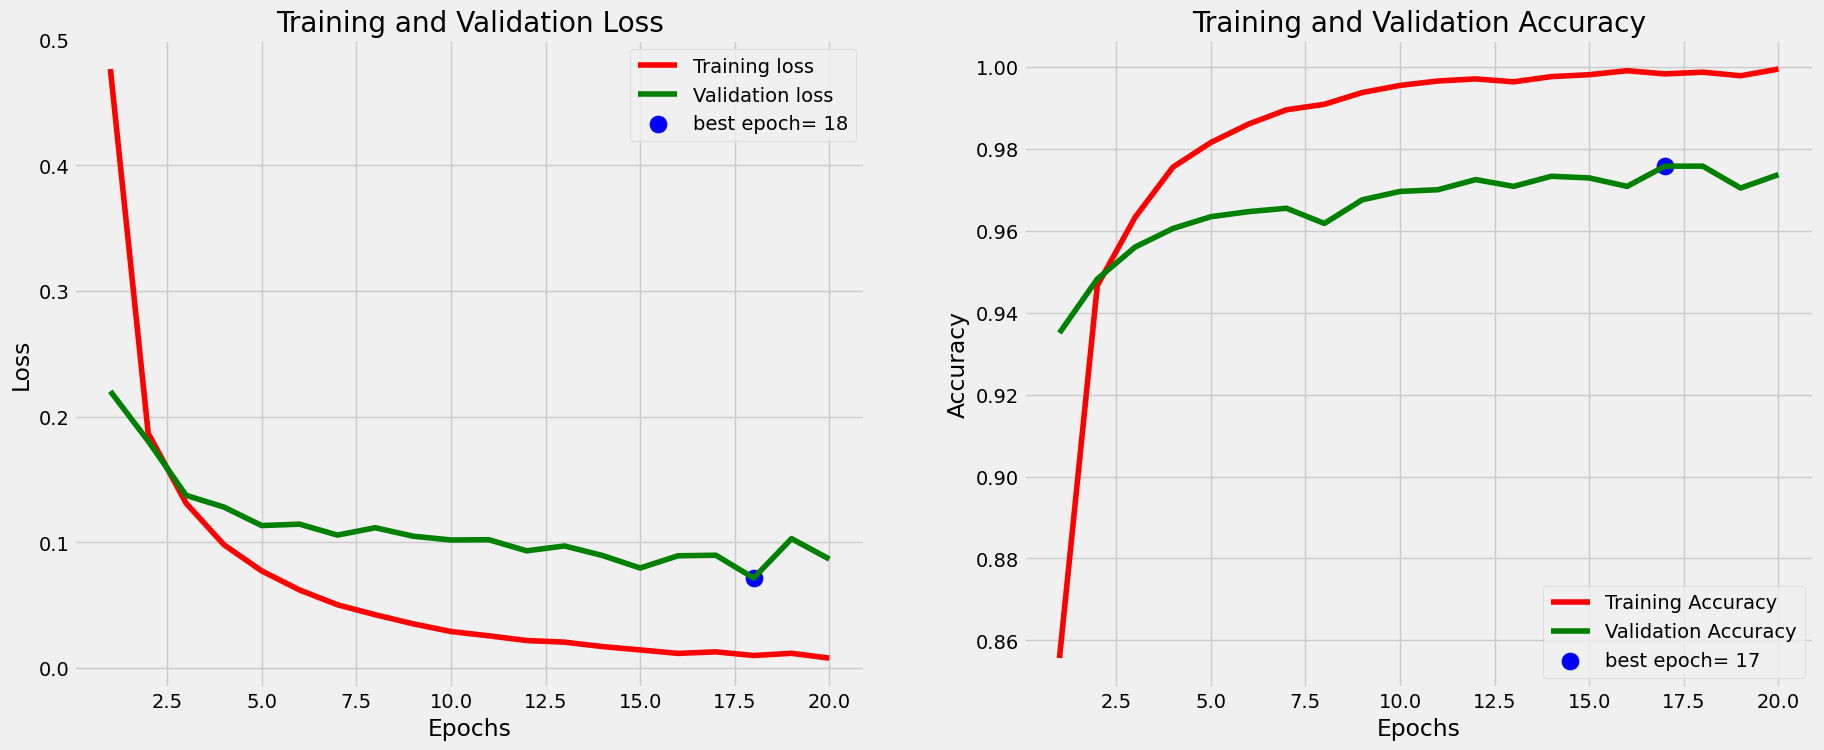

In [46]:
plot_training(resnet50_history)

In [47]:
resnet50_score = resnet50_model.evaluate(test_dataset)
resnet50_accuracy = round(resnet50_score[1] * 100, 2)
resnet50_accuracy

77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9690 - loss: 0.0871


97.15

In [48]:
resnet50_model_version = f"resnet50_{resnet50_accuracy}%"
resnet50_model_path = f"new_dataset_models/{resnet50_model_version}.keras"
resnet50_model.save(resnet50_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101

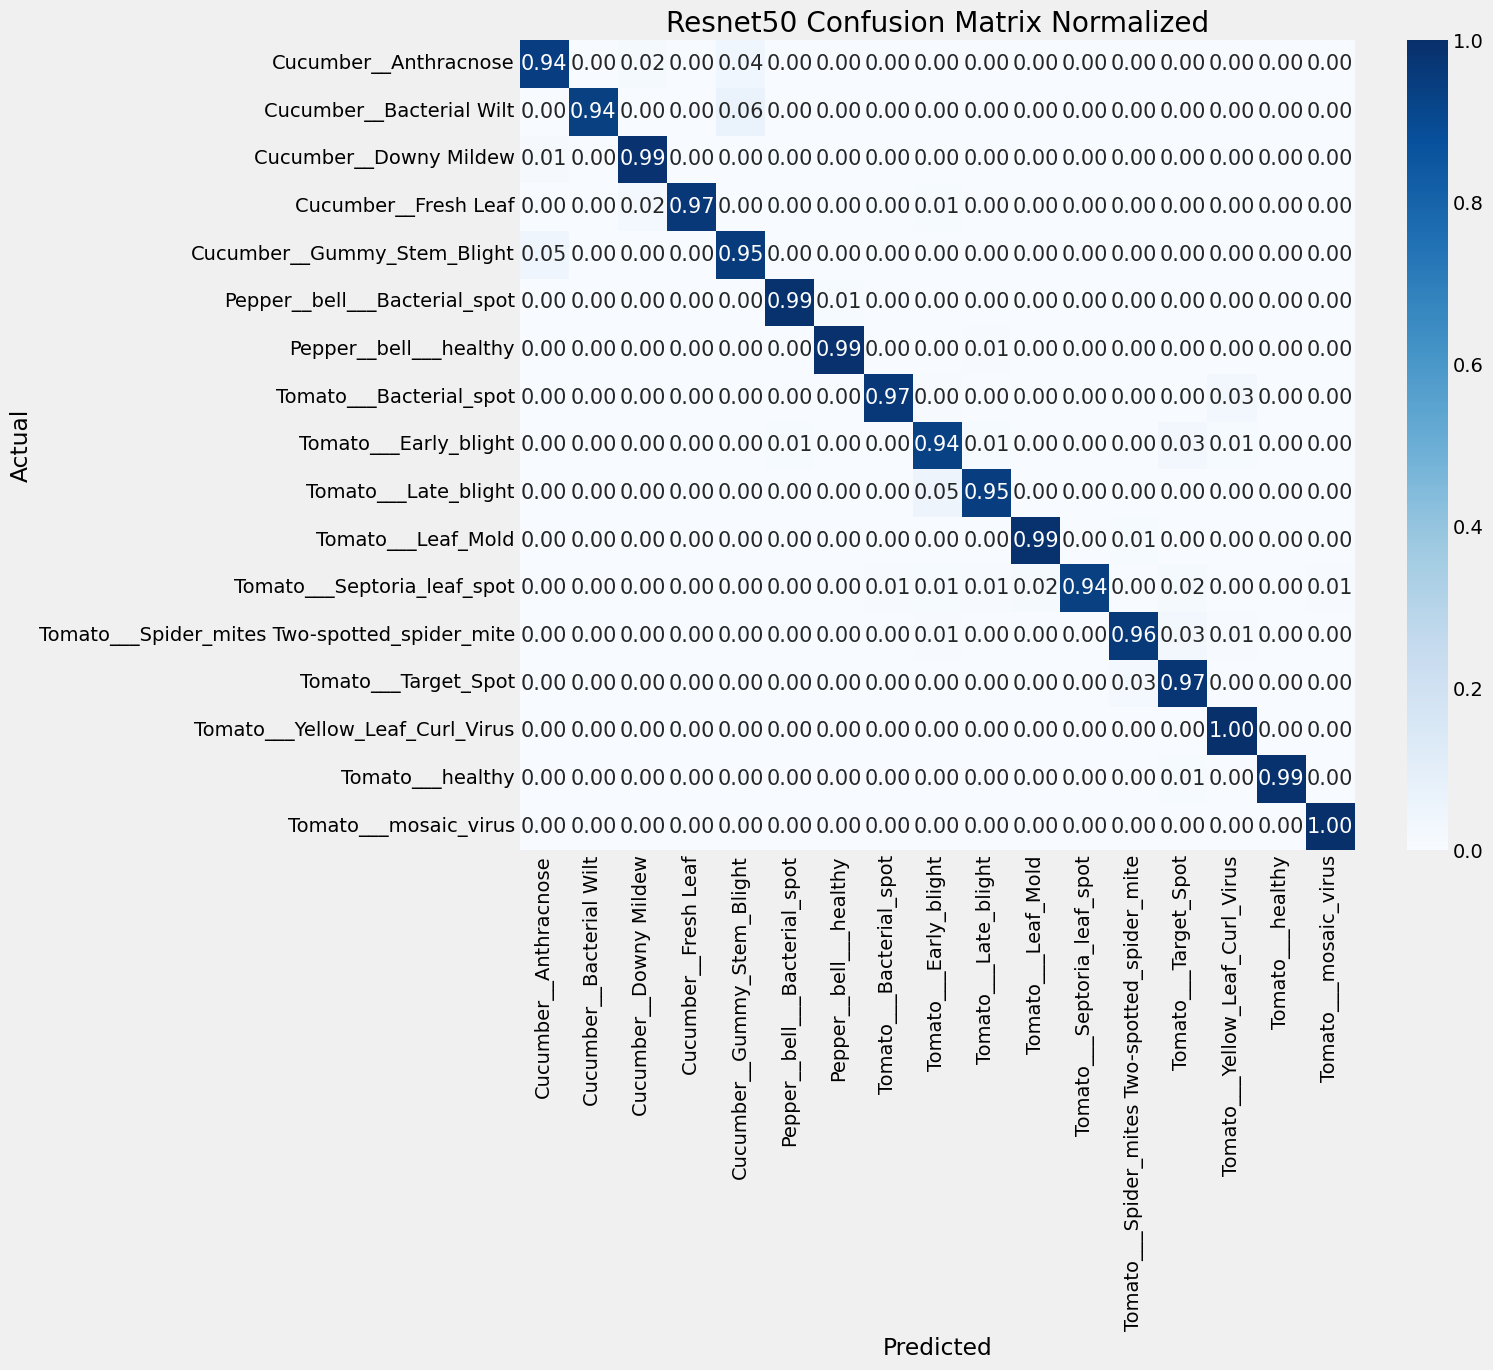

In [49]:
# Assuming cnn_model is your trained model and test_dataset is your tf.data.Dataset
resnet50_true_labels = []
resnet50_predicted_labels = []

# Iterate through the dataset to get true labels and predictions
for image_batch, label_batch in test_dataset:
    predictions = resnet50_model.predict(image_batch)
    resnet50_predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    resnet50_true_labels.extend(label_batch.numpy())

# Convert lists to tensors
resnet50_true_labels = tf.convert_to_tensor(resnet50_true_labels)
resnet50_predicted_labels = tf.convert_to_tensor(resnet50_predicted_labels)

resnet50_cm = tf.math.confusion_matrix(
    labels=resnet50_true_labels,
    predictions=resnet50_predicted_labels,
    num_classes=len(class_names),
)

# Normalize the confusion matrix
resnet50_cm_normalized = resnet50_cm / tf.reduce_sum(resnet50_cm, axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    resnet50_cm_normalized.numpy(),
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 15},  # Increase number font size
)
plt.title("Resnet50 Confusion Matrix Normalized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
print(
    classification_report(
        resnet50_true_labels, resnet50_predicted_labels, target_names=class_names
    )
)

                                               precision    recall  f1-score   support

                        Cucumber__Anthracnose       0.93      0.94      0.93        53
                     Cucumber__Bacterial Wilt       1.00      0.94      0.97        80
                       Cucumber__Downy Mildew       0.96      0.99      0.97        70
                         Cucumber__Fresh Leaf       1.00      0.97      0.98        91
                  Cucumber__Gummy_Stem_Blight       0.90      0.95      0.92        64
                Pepper__bell___Bacterial_spot       0.99      0.99      0.99        99
                       Pepper__bell___healthy       0.99      0.99      0.99       130
                      Tomato___Bacterial_spot       1.00      0.97      0.98       213
                        Tomato___Early_blight       0.85      0.94      0.89        94
                         Tomato___Late_blight       0.98      0.95      0.96       186
                           Tomato___Leaf_M

### VGG model

In [17]:
## load VGG19 model without classification layers (top layers)
vgg_base_model = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Freeze the base model to prevent its weights from being updated during training
vgg_base_model.trainable = False

# Define the model using Sequential
vgg_model = tf.keras.Sequential(
    [
        # augmentation_layers,  # Data augmentation
        vgg_base_model,  # Add the pre-trained base model
        layers.Flatten(),  # Flatten layer
        layers.Dense(n_classes, activation="softmax"),  # Output layer
    ]
)
vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │       557,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,581,457 (78.51 MB)

 Trainable params: 557,073 (2.13 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [18]:
vgg_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [21]:
vgg_history = vgg_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs_transfer,
)

Epoch 1/20


I0000 00:00:1737808949.873542   16116 service.cc:148] XLA service 0x40277090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737808949.883240   16116 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-25 14:42:29.941514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737808950.189439   16116 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-25 14:42:32.450725: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/610 ━━━━━━━━━━━━━━━━━━━━ 2:24:16 14s/step - accuracy: 0.0938 - loss: 13.5258

I0000 00:00:1737808963.049734   16116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


610/610 ━━━━━━━━━━━━━━━━━━━━ 115s 166ms/step - accuracy: 0.7402 - loss: 8.3934 - val_accuracy: 0.9104 - val_loss: 3.4390
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9503 - loss: 1.6184 - val_accuracy: 0.9231 - val_loss: 3.1940
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9674 - loss: 1.0559 - val_accuracy: 0.9243 - val_loss: 4.3878
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9697 - loss: 1.0496 - val_accuracy: 0.9256 - val_loss: 5.1750
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9758 - loss: 0.9509 - val_accuracy: 0.9371 - val_loss: 4.4354
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9814 - loss: 0.7880

2025-01-25 14:52:32.528882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9814 - loss: 0.7883 - val_accuracy: 0.9215 - val_loss: 5.9102
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9811 - loss: 0.8339 - val_accuracy: 0.9437 - val_loss: 4.8028
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9857 - loss: 0.7132 - val_accuracy: 0.9445 - val_loss: 5.0991
Epoch 9/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9844 - loss: 0.7440 - val_accuracy: 0.9482 - val_loss: 4.6558
Epoch 10/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9882 - loss: 0.4924

2025-01-25 14:59:11.289217: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 41941504 bytes after encountering the first element of size 41941504 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9882 - loss: 0.4925 - val_accuracy: 0.9301 - val_loss: 7.6503
Epoch 11/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9870 - loss: 0.7063

2025-01-25 15:00:51.001717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9870 - loss: 0.7063 - val_accuracy: 0.9272 - val_loss: 8.4768
Epoch 12/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9885 - loss: 0.6309 - val_accuracy: 0.9404 - val_loss: 7.2960
Epoch 13/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9880 - loss: 0.6162 - val_accuracy: 0.9285 - val_loss: 9.4277
Epoch 14/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.9933 - loss: 0.3022 - val_accuracy: 0.9449 - val_loss: 7.4104
Epoch 15/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9924 - loss: 0.3952 - val_accuracy: 0.9396 - val_loss: 7.4257
Epoch 16/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9931 - loss: 0.4040 - val_accuracy: 0.9474 - val_loss: 9.0374
Epoch 17/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9930 - loss: 0.3498 - val_accuracy: 0.9441 - val_loss: 7.5771
Epoch 18/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.9939 - los

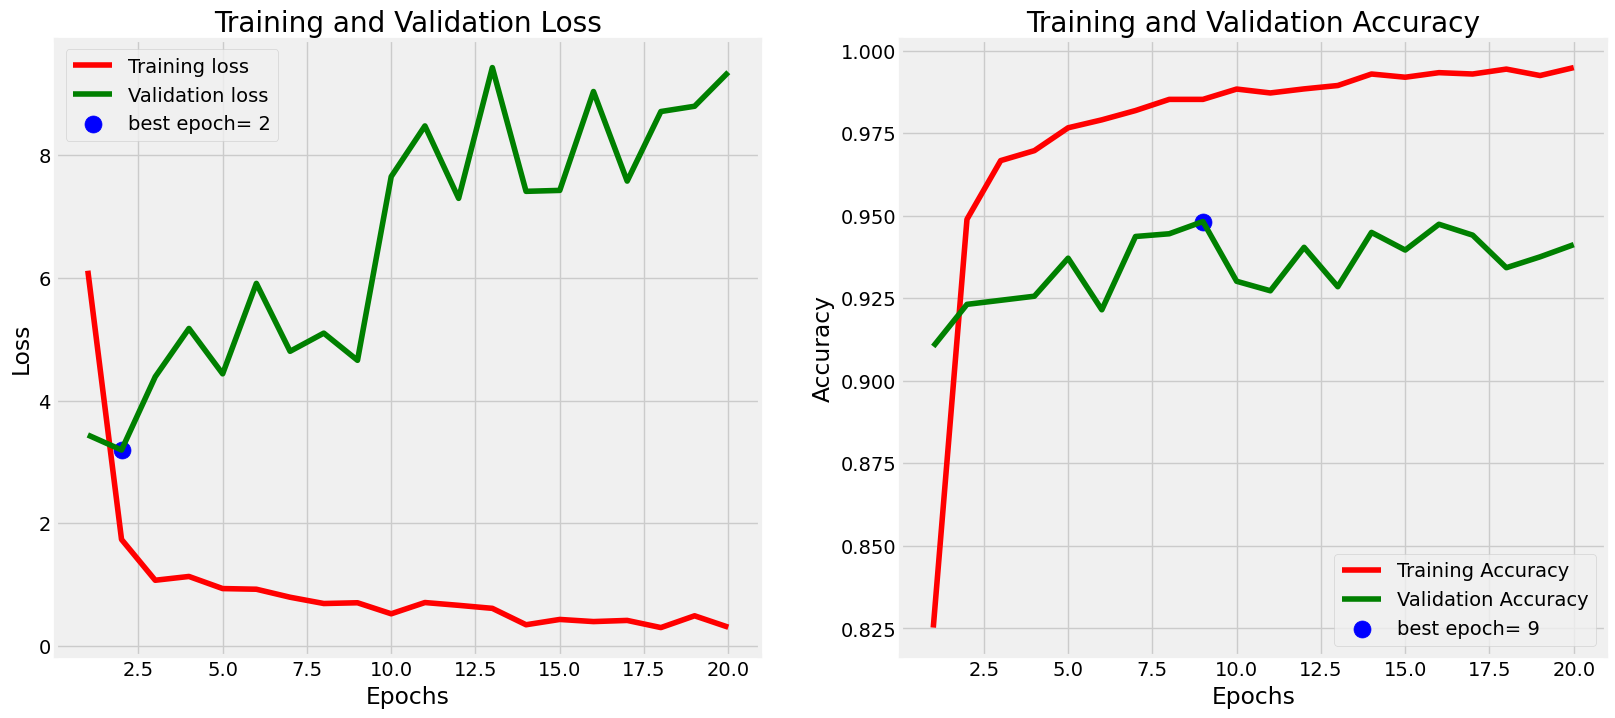

In [22]:
plot_training(vgg_history)

In [23]:
vgg_score = vgg_model.evaluate(test_dataset)
vgg_accuracy = round(vgg_score[1] * 100, 2)
vgg_accuracy

 1/77 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - accuracy: 0.9688 - loss: 13.7123

2025-01-25 15:26:39.230470: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166592 bytes after encountering the first element of size 25166592 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9321 - loss: 14.6196

2025-01-25 15:26:50.361460: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 230ms/step - accuracy: 0.9320 - loss: 14.6065


92.74

In [24]:
vgg_model_version = f"vgg19_{vgg_accuracy}%"
vgg_model_path = f"new_dataset_models/{vgg_model_version}.keras"
vgg_model.save(vgg_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

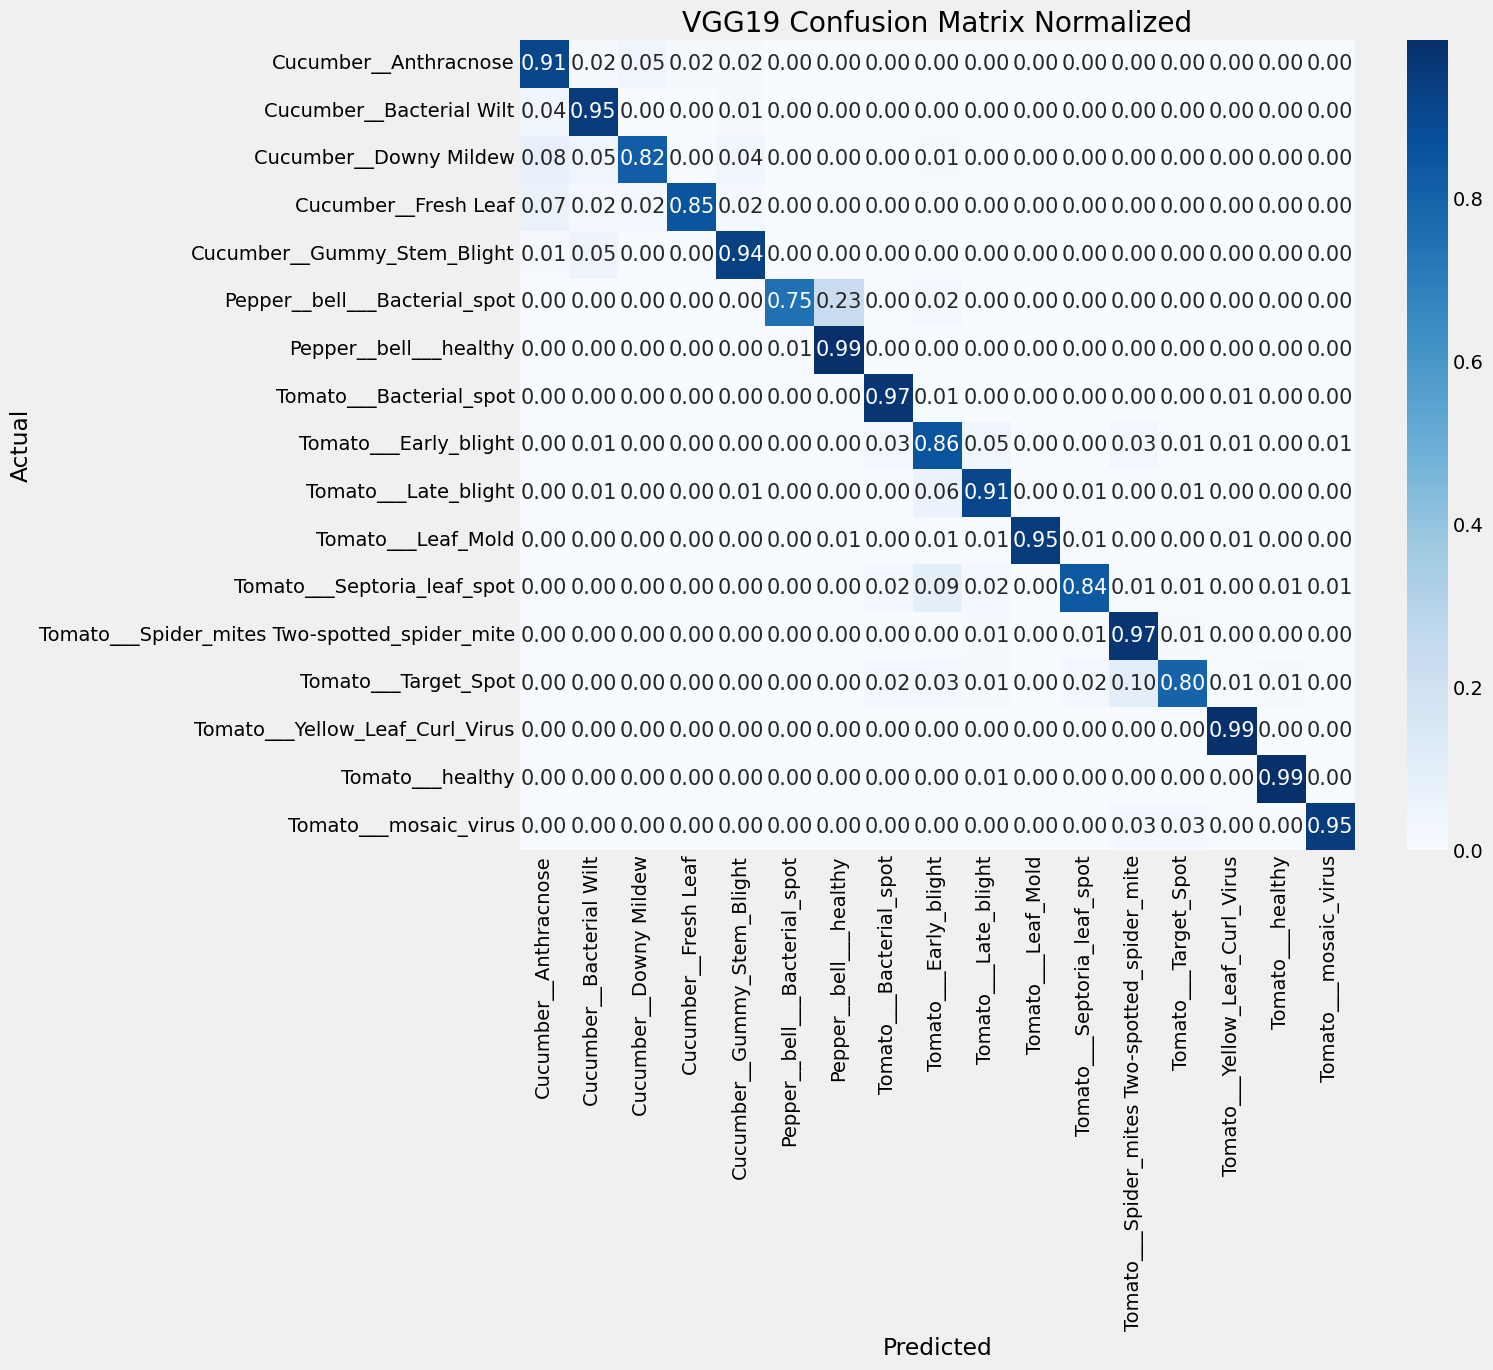

In [25]:
vgg_true_labels = []
vgg_predicted_labels = []

# Iterate through the dataset to get true labels and predictions
for image_batch, label_batch in test_dataset:
    predictions = vgg_model.predict(image_batch)
    vgg_predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    vgg_true_labels.extend(label_batch.numpy())

# Convert lists to tensors
vgg_true_labels = tf.convert_to_tensor(vgg_true_labels)
vgg_predicted_labels = tf.convert_to_tensor(vgg_predicted_labels)

vgg_cm = tf.math.confusion_matrix(
    labels=vgg_true_labels,
    predictions=vgg_predicted_labels,
    num_classes=len(class_names),
)

# Normalize the confusion matrix
vgg_cm_normalized = vgg_cm / tf.reduce_sum(vgg_cm, axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    vgg_cm_normalized.numpy(),
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 15},  # Increase numbers font size
)
plt.title("VGG19 Confusion Matrix Normalized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
print(
    classification_report(
        vgg_true_labels, vgg_predicted_labels, target_names=class_names
    )
)

                                               precision    recall  f1-score   support

                        Cucumber__Anthracnose       0.78      0.91      0.84        66
                     Cucumber__Bacterial Wilt       0.85      0.95      0.90        80
                       Cucumber__Downy Mildew       0.93      0.82      0.87        83
                         Cucumber__Fresh Leaf       0.99      0.85      0.92        82
                  Cucumber__Gummy_Stem_Blight       0.89      0.94      0.91        77
                Pepper__bell___Bacterial_spot       0.97      0.75      0.84        91
                       Pepper__bell___healthy       0.87      0.99      0.93       145
                      Tomato___Bacterial_spot       0.94      0.97      0.96       201
                        Tomato___Early_blight       0.69      0.86      0.77       107
                         Tomato___Late_blight       0.92      0.91      0.92       185
                           Tomato___Leaf_M